In [1]:
# pip install pandas scikit-learn matplotlib seaborn

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import *
from keras.utils import *
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import *
from tensorflow.keras import initializers
from tensorflow.keras.layers import GRU

import pandas as pd
import numpy as np
from datetime import datetime

from collections import *
from sklearn.utils import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
### import the data
news_data = pd.read_csv("../../data/apple_news_aggregated.csv")
news_data.head()

,date,negative,neutral,positive
0,2018-01-01,0,2,0
1,2018-01-02,1,9,0
2,2018-01-03,3,4,0
3,2018-01-04,2,3,1
4,2018-01-05,3,2,0


In [4]:
### import the data
stock_data = pd.read_csv("../../data/stock_data_final_2018_2025.csv")
stock_data.head()

,date,open,high,low,close,volume,sma_5,sma_20,ema_12,ema_26,rsi,macd,macd_signal,upper_Band,lower_Band,stoch_k,stoch_d,atr,adx
0,2018-01-01,42.630001,42.647499,42.305000,42.307499,103999600.0,42.399999,43.199125,42.778539,42.940969,36.626383,-0.162430,0.006934,44.379324,42.018926,0.132489,2.182314,0.480331,20.496033
1,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,42.458999,43.199000,42.822609,42.950156,51.991143,-0.127547,-0.019962,44.379255,42.018744,14.992662,5.083465,0.500843,19.296351
2,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,42.608999,43.199125,42.858746,42.958108,51.857092,-0.099361,-0.035842,44.379319,42.018930,29.705782,14.943644,0.511319,18.983802
3,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,42.798999,43.187374,42.920093,42.980285,55.176213,-0.060192,-0.040712,44.360309,42.014440,50.140658,31.613034,0.499617,18.693577
4,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,43.087499,43.200249,43.047771,43.037301,62.104664,0.010470,-0.030475,44.391804,42.008695,66.314014,48.720151,0.505716,19.332961


In [5]:
stock_with_sentiment_data = pd.merge(stock_data, news_data, left_on='date', right_on='date', how='left')
stock_with_sentiment_data.head()

,date,open,high,low,close,volume,sma_5,sma_20,ema_12,ema_26,...,macd_signal,upper_Band,lower_Band,stoch_k,stoch_d,atr,adx,negative,neutral,positive
0,2018-01-01,42.630001,42.647499,42.305000,42.307499,103999600.0,42.399999,43.199125,42.778539,42.940969,...,0.006934,44.379324,42.018926,0.132489,2.182314,0.480331,20.496033,0,2,0
1,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,42.458999,43.199000,42.822609,42.950156,...,-0.019962,44.379255,42.018744,14.992662,5.083465,0.500843,19.296351,1,9,0
2,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,42.608999,43.199125,42.858746,42.958108,...,-0.035842,44.379319,42.018930,29.705782,14.943644,0.511319,18.983802,3,4,0
3,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,42.798999,43.187374,42.920093,42.980285,...,-0.040712,44.360309,42.014440,50.140658,31.613034,0.499617,18.693577,2,3,1
4,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,43.087499,43.200249,43.047771,43.037301,...,-0.030475,44.391804,42.008695,66.314014,48.720151,0.505716,19.332961,3,2,0


In [6]:
stock_with_sentiment_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'sma_5', 'sma_20',
       'ema_12', 'ema_26', 'rsi', 'macd', 'macd_signal', 'upper_Band',
       'lower_Band', 'stoch_k', 'stoch_d', 'atr', 'adx', 'negative', 'neutral',
       'positive'],
      dtype='object')

In [7]:
stock_with_sentiment_data['target_close'] = stock_with_sentiment_data['close'].shift(-1)
stock_with_sentiment_data

,date,open,high,low,close,volume,sma_5,sma_20,ema_12,ema_26,...,upper_Band,lower_Band,stoch_k,stoch_d,atr,adx,negative,neutral,positive,target_close
0,2018-01-01,42.630001,42.647499,42.305000,42.307499,103999600.0,42.399999,43.199125,42.778539,42.940969,...,44.379324,42.018926,0.132489,2.182314,0.480331,20.496033,0,2,0,43.064999
1,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,42.458999,43.199000,42.822609,42.950156,...,44.379255,42.018744,14.992662,5.083465,0.500843,19.296351,1,9,0,43.057499
2,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,42.608999,43.199125,42.858746,42.958108,...,44.379319,42.018930,29.705782,14.943644,0.511319,18.983802,3,4,0,43.257500
3,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,42.798999,43.187374,42.920093,42.980285,...,44.360309,42.014440,50.140658,31.613034,0.499617,18.693577,2,3,1,43.750000
4,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,43.087499,43.200249,43.047771,43.037301,...,44.391804,42.008695,66.314014,48.720151,0.505716,19.332961,3,2,0,43.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,2025-04-27,206.369995,209.750000,206.199997,209.279999,38222300.0,208.162000,198.834999,203.637482,203.551848,...,215.043319,182.626679,85.648072,83.804139,8.008324,21.354716,1,0,3,210.139999
2674,2025-04-28,210.000000,211.500000,207.460007,210.139999,38743100.0,209.269998,200.720999,204.637870,204.039859,...,212.318059,189.123939,88.096709,86.333407,7.724872,20.815254,4,3,4,211.210007
2675,2025-04-29,208.690002,212.240005,208.369995,211.210007,36827600.0,209.838000,201.338999,205.648968,204.570981,...,213.759460,188.918539,91.104717,88.283166,7.449524,20.435112,5,3,0,212.500000
2676,2025-04-30,209.300003,213.580002,206.669998,212.500000,52286500.0,210.482001,202.442999,206.702973,205.158316,...,214.709264,190.176735,94.864740,91.355389,7.410987,19.700269,4,11,3,213.320007


In [8]:
stock_with_sentiment_data = stock_with_sentiment_data.drop([2677])
stock_with_sentiment_data

,date,open,high,low,close,volume,sma_5,sma_20,ema_12,ema_26,...,upper_Band,lower_Band,stoch_k,stoch_d,atr,adx,negative,neutral,positive,target_close
0,2018-01-01,42.630001,42.647499,42.305000,42.307499,103999600.0,42.399999,43.199125,42.778539,42.940969,...,44.379324,42.018926,0.132489,2.182314,0.480331,20.496033,0,2,0,43.064999
1,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,42.458999,43.199000,42.822609,42.950156,...,44.379255,42.018744,14.992662,5.083465,0.500843,19.296351,1,9,0,43.057499
2,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,42.608999,43.199125,42.858746,42.958108,...,44.379319,42.018930,29.705782,14.943644,0.511319,18.983802,3,4,0,43.257500
3,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,42.798999,43.187374,42.920093,42.980285,...,44.360309,42.014440,50.140658,31.613034,0.499617,18.693577,2,3,1,43.750000
4,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,43.087499,43.200249,43.047771,43.037301,...,44.391804,42.008695,66.314014,48.720151,0.505716,19.332961,3,2,0,43.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2025-04-26,206.369995,209.750000,206.199997,209.279999,38222300.0,206.254001,197.443999,202.611570,203.093596,...,214.576675,180.311324,85.255441,80.031103,8.351271,22.240426,5,12,8,209.279999
2673,2025-04-27,206.369995,209.750000,206.199997,209.279999,38222300.0,208.162000,198.834999,203.637482,203.551848,...,215.043319,182.626679,85.648072,83.804139,8.008324,21.354716,1,0,3,210.139999
2674,2025-04-28,210.000000,211.500000,207.460007,210.139999,38743100.0,209.269998,200.720999,204.637870,204.039859,...,212.318059,189.123939,88.096709,86.333407,7.724872,20.815254,4,3,4,211.210007
2675,2025-04-29,208.690002,212.240005,208.369995,211.210007,36827600.0,209.838000,201.338999,205.648968,204.570981,...,213.759460,188.918539,91.104717,88.283166,7.449524,20.435112,5,3,0,212.500000


In [9]:
stock_with_sentiment_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'sma_5', 'sma_20',
       'ema_12', 'ema_26', 'rsi', 'macd', 'macd_signal', 'upper_Band',
       'lower_Band', 'stoch_k', 'stoch_d', 'atr', 'adx', 'negative', 'neutral',
       'positive', 'target_close'],
      dtype='object')

## correlation

In [10]:
### select the features to work on
Data = stock_with_sentiment_data.copy()
Data = Data[['date',
             'open',
             'high',
             'low',
             'close',
             'volume',
             'sma_5', 'sma_20',
             'ema_12', 'ema_26', 
             'rsi', 
             'macd', 'macd_signal', 
             'upper_Band','lower_Band', 
             'stoch_k', 'stoch_d', 
             'atr', 'adx',
            #  'negative', 'neutral', 'positive',
             'target_close'
            ]]

Data = Data.sort_values(['date'])
Data

,date,open,high,low,close,volume,sma_5,sma_20,ema_12,ema_26,rsi,macd,macd_signal,upper_Band,lower_Band,stoch_k,stoch_d,atr,adx,target_close
0,2018-01-01,42.630001,42.647499,42.305000,42.307499,103999600.0,42.399999,43.199125,42.778539,42.940969,36.626383,-0.162430,0.006934,44.379324,42.018926,0.132489,2.182314,0.480331,20.496033,43.064999
1,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,42.458999,43.199000,42.822609,42.950156,51.991143,-0.127547,-0.019962,44.379255,42.018744,14.992662,5.083465,0.500843,19.296351,43.057499
2,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,42.608999,43.199125,42.858746,42.958108,51.857092,-0.099361,-0.035842,44.379319,42.018930,29.705782,14.943644,0.511319,18.983802,43.257500
3,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,42.798999,43.187374,42.920093,42.980285,55.176213,-0.060192,-0.040712,44.360309,42.014440,50.140658,31.613034,0.499617,18.693577,43.750000
4,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,43.087499,43.200249,43.047771,43.037301,62.104664,0.010470,-0.030475,44.391804,42.008695,66.314014,48.720151,0.505716,19.332961,43.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2025-04-26,206.369995,209.750000,206.199997,209.279999,38222300.0,206.254001,197.443999,202.611570,203.093596,56.324729,-0.482026,-3.036244,214.576675,180.311324,85.255441,80.031103,8.351271,22.240426,209.279999
2673,2025-04-27,206.369995,209.750000,206.199997,209.279999,38222300.0,208.162000,198.834999,203.637482,203.551848,56.324729,0.085634,-2.411869,215.043319,182.626679,85.648072,83.804139,8.008324,21.354716,210.139999
2674,2025-04-28,210.000000,211.500000,207.460007,210.139999,38743100.0,209.269998,200.720999,204.637870,204.039859,57.163545,0.598010,-1.809893,212.318059,189.123939,88.096709,86.333407,7.724872,20.815254,211.210007
2675,2025-04-29,208.690002,212.240005,208.369995,211.210007,36827600.0,209.838000,201.338999,205.648968,204.570981,58.238235,1.077986,-1.232317,213.759460,188.918539,91.104717,88.283166,7.449524,20.435112,212.500000


Text(0.5, 1.0, 'The correlation between features')

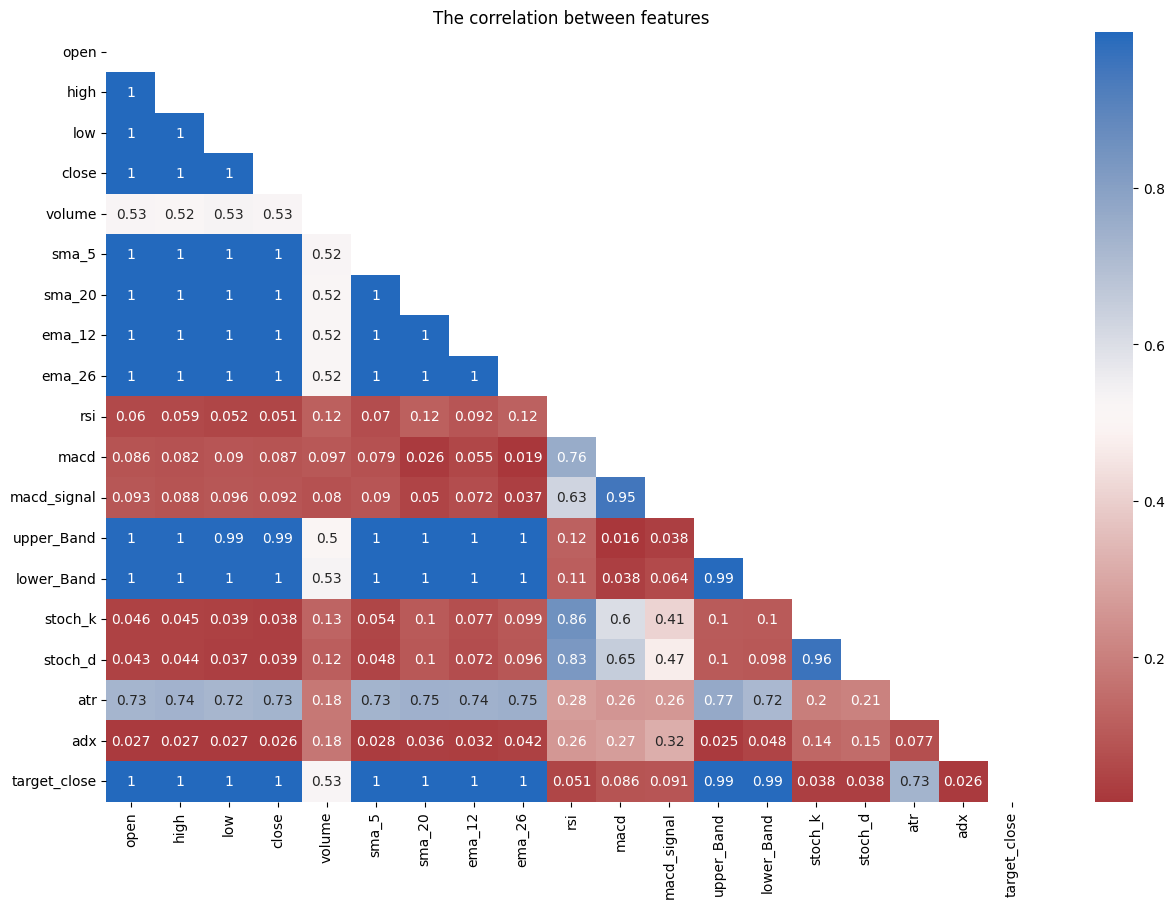

In [11]:
numeric_data = Data.select_dtypes(include=[np.number])


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
mask = np.triu(np.ones_like(numeric_data.corr(), dtype=bool))
sns.heatmap(np.abs(numeric_data.corr()), mask=mask, annot=True, cmap='vlag_r', ax=ax)
plt.title('The correlation between features')

## scaling and creating data sequence 

In [12]:
#Data[c] = (Data[c] - Data[c].min()) / (Data[c].max() - Data[c].min())
trg_min = Data['target_close'].min()
trg_max = Data['target_close'].max()
trg_min,trg_max

(np.float64(35.54750061035156), np.float64(259.0199890136719))

In [13]:
#Scaling each column separately
for c in Data.columns[1:]:
    Data[c] = (Data[c] - Data[c].min()) / (Data[c].max() - Data[c].min())

In [14]:
WINDOW_SIZE = 5
data_x, data_y = [], []


for i in range(WINDOW_SIZE,len(Data)):
    data_x.append(Data.iloc[i-WINDOW_SIZE:i, 1:-1])
    data_y.append((Data.iloc[i, -1]))

In [15]:
data_x, data_y = np.array(data_x), np.array(data_y)

## spliting data

In [16]:
data_x.shape[0]

2672

In [17]:
limiter = 8 * (data_x.shape[0] // 10)

trainV_data_x = data_x[:limiter, :, :]
trainV_data_y = data_y[:limiter]

test_data_x = data_x[limiter:, :, :]
test_data_y = data_y[limiter:]

In [18]:
limiterValid = 8 * (trainV_data_x.shape[0] // 10)

valid_data_x = trainV_data_x[limiterValid:, :, :]
valid_data_y = trainV_data_y[limiterValid:]

train_data_x = trainV_data_x[:limiterValid, :, :]
train_data_y = trainV_data_y[:limiterValid]

In [19]:
valid_data_x.shape,valid_data_y.shape

((432, 5, 18), (432,))

In [20]:
valid_data_y[:10]

array([0.53882474, 0.53211251, 0.54513419, 0.54513419, 0.54513419,
       0.57225161, 0.52933807, 0.53591607, 0.52276007, 0.51528713])

In [21]:
train_data_x.shape,train_data_y.shape

((1704, 5, 18), (1704,))

In [22]:
train_data_y[:10]

array([0.03670474, 0.03597759, 0.03595521, 0.03591045, 0.03701798,
       0.03904283, 0.03904283, 0.03904283, 0.03904283, 0.038036  ])

In [23]:
test_data_x.shape,test_data_y.shape

((536, 5, 18), (536,))

In [24]:
test_data_y[:10]

array([0.66787864, 0.67969218, 0.68224279, 0.68985004, 0.68976053,
       0.68976053, 0.68976053, 0.69763619, 0.6940116 , 0.69700972])

# Training

In [25]:
kernel_initializer=initializers.RandomNormal(stddev=0.01)
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

model = Sequential()


model.add(GRU(units=60, activation='relu',
               input_shape=(int(train_data_x.shape[1]),int(train_data_x.shape[2])),
               return_sequences=True))


model.add(GRU(units=35 ,return_sequences=False))
model.add(Dense(1))
model.add(Activation('relu'))


model.summary()

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 60)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 35)             │        10,185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,621 (96.18 KB)

 Trainable params: 24,621 (96.18 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2])

In [28]:
history = model.fit(train_data_x, train_data_y, epochs=100, batch_size=48, validation_data=(valid_data_x, valid_data_y), verbose=1, callbacks=[
    ReduceLROnPlateau(monitor="val_r2", patience=15, factor=.1),
    EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=45)
])

Epoch 1/100


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0230 - r2: -86.3153 - val_loss: 0.0031 - val_r2: -421.7750 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9376e-04 - r2: -93.0604 - val_loss: 9.8226e-04 - val_r2: -173.6713 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8918e-04 - r2: -95.1949 - val_loss: 6.8183e-04 - val_r2: -141.5298 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4950e-04 - r2: -95.2368 - val_loss: 5.9705e-04 - val_r2: -131.1790 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0404e-04 - r2: -94.9069 - val_loss: 4.2316e-04 - val_r2: -111.5852 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0599e-04 - r2: -94.7308 - val_loss: 4.1955e-04 - val_r2: -111.2509 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7800e-04 - r2: -95.2984 - val_loss: 3.6718e-04 

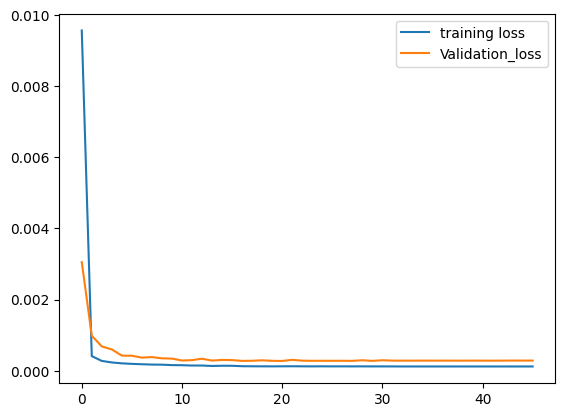

In [29]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend()

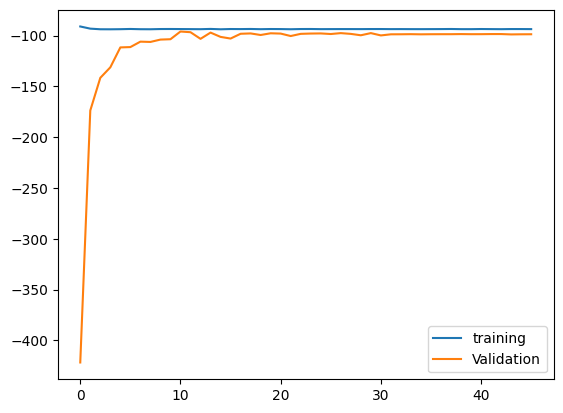

In [30]:
plt.plot(history.history['r2'], label='training')
plt.plot(history.history['val_r2'], label='Validation')
plt.legend()

In [31]:
predictions = model.predict(test_data_x)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [32]:
Predictions = []
for i in range(len(predictions)):
    Predictions.append(predictions[i]*(trg_max-trg_min)+trg_min)

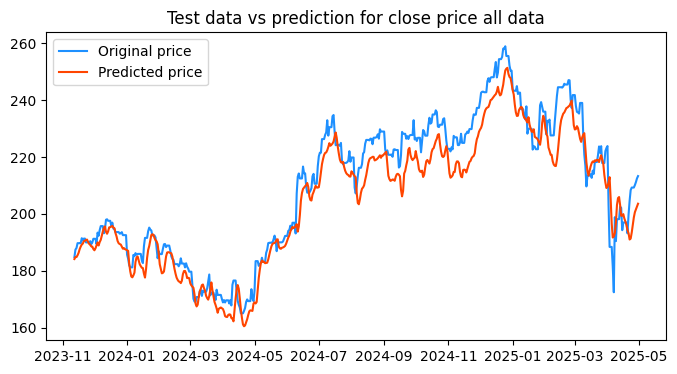

In [33]:
results = {'date' : stock_with_sentiment_data.date[limiter+WINDOW_SIZE:],
           'original': stock_with_sentiment_data.target_close[limiter+WINDOW_SIZE:],
          'predictions':Predictions
          }
df_results = pd.DataFrame(results) 
df_results.date = pd.to_datetime(df_results.date)
df_results.index = df_results.date

fig, ax = plt.subplots(figsize=(8,4))
ax.set_facecolor('#FFFFFF')
ax.plot(df_results['original'], color='dodgerblue', label='Original price')
plt.plot(df_results['predictions'], color='orangered', label='Predicted price')
plt.title('Test data vs prediction for close price all data')
plt.legend()

In [34]:
df_results = df_results[:-1]

In [35]:
r2 = r2_score(df_results['original'], df_results['predictions'])
mse = mean_squared_error(df_results['original'], df_results['predictions'])
mae = mean_absolute_error(df_results['original'], df_results['predictions'])
rmse = np.sqrt(mse)
print('R2 score is -> ', r2)
print('RMSE is -> ', rmse)

R2 score is ->  0.9031688619927748
RMSE is ->  7.558242216285432


In [36]:
df_results

,date,original,predictions
date,,,
2023-11-12,2023-11-12,184.800003,[184.11060967968297]
2023-11-13,2023-11-13,187.440002,[184.84753858498607]
2023-11-14,2023-11-14,188.009995,[184.80664619024083]
2023-11-15,2023-11-15,189.710007,[185.44985558758708]
2023-11-16,2023-11-16,189.690002,[186.32151627557687]
...,...,...,...
2025-04-25,2025-04-25,209.279999,[196.20267728582712]
2025-04-26,2025-04-26,209.279999,[198.73326384064148]
2025-04-27,2025-04-27,210.139999,[200.6069080798743]


In [37]:
df_results.dtypes

date           datetime64[ns]
original              float64
predictions            object
dtype: object

In [38]:
df_results['predictions'] = df_results['predictions'].apply(lambda x: x[0])

In [39]:
df_results

,date,original,predictions
date,,,
2023-11-12,2023-11-12,184.800003,184.110610
2023-11-13,2023-11-13,187.440002,184.847539
2023-11-14,2023-11-14,188.009995,184.806646
2023-11-15,2023-11-15,189.710007,185.449856
2023-11-16,2023-11-16,189.690002,186.321516
...,...,...,...
2025-04-25,2025-04-25,209.279999,196.202677
2025-04-26,2025-04-26,209.279999,198.733264
2025-04-27,2025-04-27,210.139999,200.606908


In [40]:
df_results['original_prev'] = df_results['original'].shift(1)

In [41]:
df_results

,date,original,predictions,original_prev
date,,,,
2023-11-12,2023-11-12,184.800003,184.110610,NaN
2023-11-13,2023-11-13,187.440002,184.847539,184.800003
2023-11-14,2023-11-14,188.009995,184.806646,187.440002
2023-11-15,2023-11-15,189.710007,185.449856,188.009995
2023-11-16,2023-11-16,189.690002,186.321516,189.710007
...,...,...,...,...
2025-04-25,2025-04-25,209.279999,196.202677,209.279999
2025-04-26,2025-04-26,209.279999,198.733264,209.279999
2025-04-27,2025-04-27,210.139999,200.606908,209.279999


In [42]:
# Вычисляем дельты (направление движения)
df_results['true_diff'] = df_results['original'] - df_results['original_prev']
df_results['pred_diff'] = df_results['predictions'] - df_results['original_prev']

In [43]:
df_results

,date,original,predictions,original_prev,true_diff,pred_diff
date,,,,,,
2023-11-12,2023-11-12,184.800003,184.110610,NaN,NaN,NaN
2023-11-13,2023-11-13,187.440002,184.847539,184.800003,2.639999,0.047536
2023-11-14,2023-11-14,188.009995,184.806646,187.440002,0.569992,-2.633356
2023-11-15,2023-11-15,189.710007,185.449856,188.009995,1.700012,-2.560139
2023-11-16,2023-11-16,189.690002,186.321516,189.710007,-0.020004,-3.388490
...,...,...,...,...,...,...
2025-04-25,2025-04-25,209.279999,196.202677,209.279999,0.000000,-13.077321
2025-04-26,2025-04-26,209.279999,198.733264,209.279999,0.000000,-10.546735
2025-04-27,2025-04-27,210.139999,200.606908,209.279999,0.860001,-8.673091


In [44]:
df_results['correct_direction'] = np.sign(df_results['true_diff']) == np.sign(df_results['pred_diff'])
accuracy = df_results['correct_direction'].iloc[1:].mean()
print(f"Accuracy предсказанного направления движения цены: {accuracy:.2%}")

Accuracy предсказанного направления движения цены: 31.84%
